In [47]:
import torch
import shap
import numpy as np
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import condensa

In [48]:
# Data
from sklearn.model_selection import train_test_split

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)

VAL_SIZE = 0.1
BATCH_SIZE = 64
batch_size_train = 64
batch_size_test = 1000


cifar10_train = torchvision.datasets.CIFAR10('/home/yoshisada/Desktop/condensa/notebooks/files', train=True, download=True,
                             transform=transform_train)

cifar10_test = torchvision.datasets.CIFAR10('/home/yoshisada/Desktop/condensa/notebooks/files', train=False, download=True,
                             transform=transform_test)

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(cifar10_train)),
    cifar10_train.targets,
    stratify=cifar10_train.targets,
    test_size=VAL_SIZE,
)

# generate subset based on indices
train_split = torch.utils.data.Subset(cifar10_train, train_indices)
val_split = torch.utils.data.Subset(cifar10_train, val_indices)

# create batches
trainloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size_train, shuffle=True)
valloader = torch.utils.data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size_test, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [49]:
import torch.nn as nn


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [50]:
# TODO: load in the model that you would like to inspect

model_cpu = VGG()

# Define the file path of the checkpoint
checkpoint_path = '/home/yoshisada/Desktop/CIFAR10_Models/pytorch-cifar/checkpoint/VGG19_92ACC.pth'

# Load the checkpoint file
checkpoint = torch.load(checkpoint_path)
# checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# remove modeule prefix on values
remove_prefix = 'module.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in checkpoint["net"].items()}

# Load the state of the neural network
model_cpu.load_state_dict(state_dict)

<All keys matched successfully>

In [51]:
# specify loss function
criterion = nn.CrossEntropyLoss()

In [52]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [53]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_cpu.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        '''
        fix to speed up accuracy calculation
        move model to the gpu 
        '''
        model_cpu = model_cpu.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_cpu(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

'''
move model back to cpu to avoid any issues
'''
model_cpu = model_cpu.cpu()

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

accuracy = '{:.0f}'.format(100. * np.sum(class_correct) / np.sum(class_total))
print('acc value:', accuracy)

Test Loss: 0.333060

Test Accuracy of plane: 98% (65/66)
Test Accuracy of   car: 100% (56/56)
Test Accuracy of  bird: 81% (50/61)
Test Accuracy of   cat: 84% (61/72)
Test Accuracy of  deer: 96% (77/80)
Test Accuracy of   dog: 90% (48/53)
Test Accuracy of  frog: 94% (55/58)
Test Accuracy of horse: 95% (65/68)
Test Accuracy of  ship: 95% (63/66)
Test Accuracy of truck: 88% (53/60)

Test Accuracy (Overall): 92% (593/640)
acc value: 93


In [54]:
batch = next(iter(testloader))
images, _ = batch

background = images[:100]
test_images = images[100:101]

In [55]:
# function to get shap values 
def shapVals(model):
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)

    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

    return (shap_numpy, test_numpy)

In [56]:
model_cpu.load_state_dict(state_dict)

<All keys matched successfully>

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


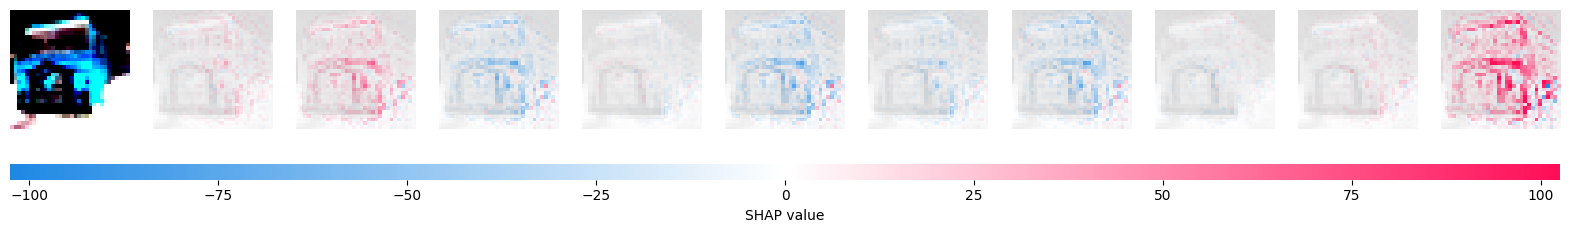

In [57]:
# print out ORIGINAL MODEL shap values
shap_numpy, test_numpy = shapVals(model_cpu)
shap.image_plot(shap_numpy, -test_numpy)

In [58]:
#lets compress

In [59]:
assert torch.cuda.is_available()

In [60]:
criterion = nn.CrossEntropyLoss().cuda()

In [61]:
import logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [62]:
import logging
import json
import re

import torch
import torch.nn

import condensa
import condensa.functional as F
import condensa.tensor as T
from   condensa.schemes import (
    LayerBlockPruner,
    LayerPruner,
    NetworkPruner
)

import torchvision.models as models

In [63]:
vgg = VGG()
checkpoint_path = '/home/yoshisada/Desktop/CIFAR10_Models/pytorch-cifar/checkpoint/VGG19_92ACC.pth'

# Load the checkpoint file
checkpoint = torch.load(checkpoint_path)

# remove modeule prefix on values
remove_prefix = 'module.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in checkpoint["net"].items()}

# Load the state of the neural network
vgg.load_state_dict(state_dict)

for name, m in vgg.named_modules():
    print("name")
    print(name)
    print("m")
    print(m)

modules = []
for name, m in vgg.named_modules():
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        modules.append(name)

print(modules)

name

m
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(

In [64]:
def nparams(model, modules):
    nparams = 0
    for name, m in model.named_modules():
        if name in modules:
            nparams += m.weight.data.view(-1).nonzero().numel()
    return nparams


def nparams_full(model):
    return torch.nn.utils.parameters_to_vector(
           model.parameters()).view(-1).nonzero().numel()


vgg = VGG()
vgg_path = '/home/yoshisada/Desktop/CIFAR10_Models/pytorch-cifar/checkpoint/VGG19_92ACC.pth'

vgg_load = torch.load(vgg_path)

# remove modeule prefix on values
remove_prefix = 'module.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in vgg_load["net"].items()}

# Load the state of the neural network
vgg.load_state_dict(state_dict)

# model = models.resnet50(pretrained=False, progress=True)
model = vgg

modules = []

# for name, m in model.named_modules():
#     print("name")
#     print(name)
#     print("m")
#     print(m)

for name, m in model.named_modules():
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        modules.append(name)

npo, npo_full = nparams(model, modules), nparams_full(model)

scheme = condensa.schemes.parse("./examples/schemes/prune_0.5.json", modules)
with condensa.save_masks():
    scheme.pi(model)

npc, npc_full = nparams(model, modules), nparams_full(model)
cratio = float(npo) / float(npc)
cratio_full = float(npo_full) / float(npc_full)
print(f'compression ratio (effective,full): ({cratio},{cratio_full})')


torch.save(model.state_dict(), "/home/yoshisada/Desktop/ExplainabilityResearch/vgg_comp.pt")
print('Compressed model saved to disk')

compression ratio (effective,full): (6.666666666666667,6.635666373742517)
Compressed model saved to disk


In [65]:
compressed = VGG()
compressed.load_state_dict(torch.load("/home/yoshisada/Desktop/ExplainabilityResearch/vgg_comp.pt"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


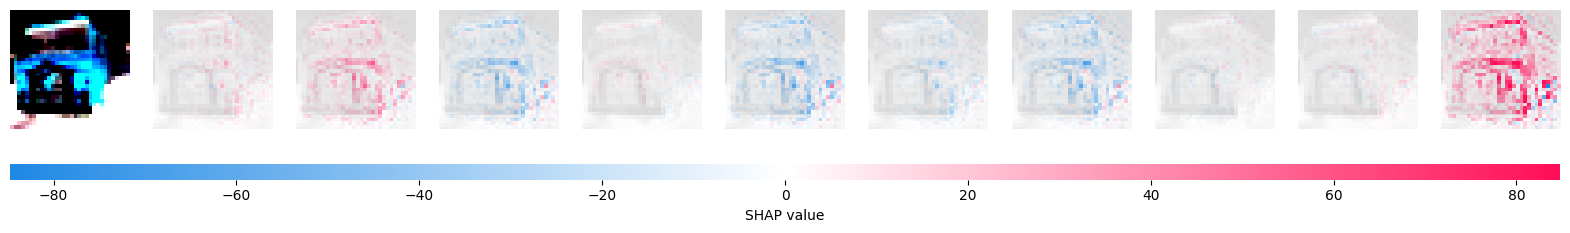

In [66]:
# print out ORIGINAL MODEL shap values
shap_numpy, test_numpy = shapVals(compressed)
shap.image_plot(shap_numpy, -test_numpy)

In [67]:
def countZeroWeights(model):
    non_zeros = 0
    for param in model.parameters():
        if param is not None:
            non_zeros += torch.sum((param != 0).int()).item()

    return non_zeros

In [68]:
print("number of non-zeros unpruned", countZeroWeights(model_cpu))
print("number of non-zeros pruned", countZeroWeights(compressed))

number of non-zeros unpruned 20040522
number of non-zeros pruned 3020122


In [69]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

compressed.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        '''
        fix to speed up accuracy calculation
        move model to the gpu 
        '''
        compressed = compressed.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = compressed(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

'''
move model back to cpu to avoid any issues
'''
compressed = compressed.cpu()

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

accuracy = '{:.0f}'.format(100. * np.sum(class_correct) / np.sum(class_total))
print('acc value:', accuracy)

Test Loss: 0.318820

Test Accuracy of plane: 94% (54/57)
Test Accuracy of   car: 100% (53/53)
Test Accuracy of  bird: 94% (55/58)
Test Accuracy of   cat: 81% (54/66)
Test Accuracy of  deer: 93% (54/58)
Test Accuracy of   dog: 86% (68/79)
Test Accuracy of  frog: 98% (76/77)
Test Accuracy of horse: 95% (61/64)
Test Accuracy of  ship: 96% (59/61)
Test Accuracy of truck: 94% (63/67)

Test Accuracy (Overall): 93% (597/640)
acc value: 93
